# 2015-2017 Bitcoin Blockchain and its actors analysis

### Summary

We will see in this analysis :
- **I/ Fees and transactions**
- **II/ Random events, price and transactions**
- **III/ Actors country and the Chinese ban on Bitcoin exchanges in 2017**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import requests
import socket
import datetime

from plotly.subplots import make_subplots


In [2]:
path_blockchain_actor = "DefiEGC2024/blockchain_by_actor.csv" 
path_external = "DefiEGC2024/external.csv" 
path_global = "DefiEGC2024/global.csv"

In [3]:
df_actor = pd.read_csv(path_blockchain_actor, index_col=0)
df_actor.head(5)

year  month  day          identity      received  nb_received  \
0  2015.0    1.0  1.0    HappyCoins.com  1.377590e+09          4.0   
1  2015.0    1.0  1.0               821  2.476057e+09          5.0   
2  2015.0    1.0  1.0   FortuneJack.com  1.201470e+08         29.0   
3  2015.0    1.0  1.0               396  1.906135e+10         70.0   
4  2015.0    1.0  1.0  SatoshiMines.com  7.401319e+08        193.0   

         date   sum_fee  mean_fee_for100  nb_transactions          sent  \
0  2015-01-01   49596.0         0.004957              4.0  1.277500e+09   
1  2015-01-01   10000.0         0.000851              1.0  1.174552e+09   
2  2015-01-01   83000.0         0.194670             11.0  1.541127e+08   
3  2015-01-01  540000.0         0.023738             54.0  1.842989e+10   
4  2015-01-01  740000.0         0.447934             45.0  1.813624e+09   

   self_spent  self_spent_estimated  nb_spent         spent  
0         0.0                   0.0       8.0  1.277500e+09  
1         0.0                   0.0       2.0  1.174552e+09  
2  14158970.0            14158970.0      22.0  1.399538e+08  
3         0.0                   0.0     108.0  1.842989e+10  
4  35044568.0            35044568.0      84.0  1.778579e+09

This file contains time series describing the 100 actors with the highest activity (defined in terms of the number of active days) over the period.

- **identity**: Identifier of the actor, which can be a name or a unique number
- **received**: Total amount received
- **spent**: Total amount spent
- **nb_received**: Number of transaction outputs received by the actor
- **nb_transactions**: Number of transactions made by the actor
- **nb_spent**: Number of payments made by the actor (1 transaction = 1 or several payments).
- **sum_fee**: Total transaction fees paid by the actor for transactions for which he is the source
- **mean_fee_for100**: Average fees paid per transaction
- **self_spent**: Amounts observed as sent from the actor to himself
- **self_spent_estimated**: Amounts estimated as likely sent from the actor to himself, but to addresses we do not know. This value is necessarily higher than self_spent.

In [4]:
# List some actors
identity = np.array(df_actor['identity'].unique())
identity[['.' in x for x in identity]]

array(['HappyCoins.com', 'FortuneJack.com', 'SatoshiMines.com',
       'Rollin.io', 'SatoshiDice.com', 'Loanbase.com', 'Bitstamp.net',
       'Paymium.com', 'YoBit.net', 'FYBSG.com', 'Poloniex.com',
       'Bitbond.com', 'ePay.info_CoinJoinMess', 'HolyTransaction.com',
       'SlushPool.com', 'BTCJam.com', 'Matbea.com', 'TheRockTrading.com',
       'Huobi.com', 'HaoBTC.com', 'SafeDice.com', 'CoinSpot.com.au',
       'CoinMotion.com', 'Xapo.com', 'CoinGaming.io', 'OKCoin.com',
       'BitZillions.com', 'SecondsTrade.com', '999Dice.com', 'BX.in.th',
       'SimpleCoin.cz', 'BTC-e.com', 'PocketDice.io', 'BitBargain.co.uk',
       'Bter.com', 'BtcTrade.com', 'Cryptonator.com', 'BTCC.com',
       'CoinPayments.net', 'CoinCafe.com',
       'CoinTrader.net_LocalBitcoins.com', 'LuckyB.it',
       'MercadoBitcoin.com.br', 'Bitcoin.de', 'CoinJar.com', 'Bit-x.com',
       'Vaultoro.com'], dtype=object)

#### Cleaning our data

In [5]:
df_actor.dtypes

year                    float64
month                   float64
day                     float64
identity                 object
received                float64
nb_received             float64
date                     object
sum_fee                 float64
mean_fee_for100         float64
nb_transactions         float64
sent                    float64
self_spent              float64
self_spent_estimated    float64
nb_spent                float64
spent                   float64
dtype: object

In [6]:
# convert year, month and day to int
df_actor['year'] = df_actor['year'].astype(int)
df_actor['month'] = df_actor['month'].astype(int)
df_actor['day'] = df_actor['day'].astype(int)

# convert the date to datetime in year-month-day format
df_actor['date'] = pd.to_datetime(df_actor['date'], format='%Y-%m-%d')

# convert identity to string
df_actor['identity'] = df_actor['identity'].astype(str)

# convert nb_transactions, nb_received, nb_spent to int
df_actor['nb_transactions'] = df_actor['nb_transactions'].astype(int)
df_actor['nb_received'] = df_actor['nb_received'].astype(int)
df_actor['nb_spent'] = df_actor['nb_spent'].astype(int)

In [7]:
# get the year, month and day from the date
df_actor['year'] = df_actor['date'].dt.year
df_actor['month'] = df_actor['date'].dt.month
df_actor['day'] = df_actor['date'].dt.day

In [8]:
# save the df to a csv file
df_actor.to_csv('DefiEGC2024/blockchain_by_actor_cleaned.csv')

#### Biggest receivers actors

In [9]:
# Group by identity and sum the received and spent amounts
df_amount = df_actor[['identity', 'received', 'spent']].groupby('identity').sum()
df_amount

received         spent
identity                                          
0                       2.073722e+14  1.364461e+14
101                     5.399256e+12  5.214319e+12
107                     2.756361e+14  1.366241e+14
1070                    8.005035e+11  7.886356e+11
1138                    6.114027e+11  6.102002e+11
...                              ...           ...
TheRockTrading.com      4.920981e+12  3.983099e+12
Vaultoro.com            1.524106e+12  1.303786e+12
Xapo.com                2.360818e+14  1.381389e+14
YoBit.net               1.039660e+13  8.879588e+12
ePay.info_CoinJoinMess  1.188925e+15  1.169524e+15

[100 rows x 2 columns]

In [10]:
# Sort the actors by the amount received

actors_received = df_amount.sort_values(by='received', ascending=False)
actors_received.index[:5]

Index(['Huobi.com', 'ePay.info_CoinJoinMess', 'Bitstamp.net', 'BTC-e.com',
       'OKCoin.com'],
      dtype='object', name='identity')

In [11]:
# Sort the actors by the amount spent

df_amount2 = df_actor[['identity', 'received', 'spent']].groupby('identity').mean()
actors_received_mean = df_amount2.sort_values(by='received', ascending=False)
most_receiving_actor = actors_received_mean.index[:5]
most_receiving_actor

Index(['Huobi.com', 'ePay.info_CoinJoinMess', 'Bitstamp.net', 'BTC-e.com',
       'OKCoin.com'],
      dtype='object', name='identity')

In [12]:
fig = px.bar(actors_received, x=actors_received.index,
             y=actors_received['received'].values,  
             title='Biggest receivers in the bitcoin blockchain',
             labels={'x':'Identity', 'y':'Received'},
             )
fig.show()

In [13]:
def PlotActors(df, actors, column, title):
    fig = go.Figure()
    for actor in actors[:5]:
        date = df[df['identity'] == actor]['date'].values
        fig.add_trace(go.Scatter(x=date, y=df_actor[df_actor['identity'] == actor][column].rolling(30).mean(), 
                                 mode='lines', line=dict(width=1), name=actor))
        fig.update_layout(xaxis=dict(tickvals=date[::200]))
        fig.update_layout(title=title, yaxis_type="log")
        fig.update_layout(showlegend=True, legend=dict(x=0, y=0, orientation="v"))
    fig.show()

PlotActors(df_actor, most_receiving_actor, 'received', 'Top 5 actors receiving the most bitcoins')

#### Most spending actors

In [14]:
# Sort the actors by the amount spent
 
actors_spent = df_amount.sort_values(by='spent', ascending=False)
most_spending_actor = actors_spent.index[:5]
most_spending_actor


Index(['ePay.info_CoinJoinMess', 'Huobi.com', 'Bitstamp.net', 'Poloniex.com',
       'BTCC.com'],
      dtype='object', name='identity')

In [15]:
PlotActors(df_actor, most_spending_actor, 'spent', 'Top 5 actors spending the most bitcoins')

Why Huobi suddenly fall down ? 
We can found that following a 2017 ban on Bitcoin exchanges by the Chinese government, Huobi stopped Bitcoin withdrawals. Huobi China continues to operate as a blockchain consulting and research platform. 
https://en.wikipedia.org/wiki/Huobi 

Maybe it can be interesting to see the evolution of the Chinese actors. Compare the evolution of the Chinese actors with other platforms. We will analyse the evolution of the Chinese actors in the third part of this analysis.

In [16]:
# subplot of 2 pie plot with plotly with the biggest spenders and the biggest receivers

import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=actors_spent['spent'].index, values=actors_spent['spent'].values, name="Biggest spenders"), 1, 1)
fig.add_trace(go.Pie(labels=actors_received['received'].index, values=actors_received['received'].values, name="Biggest receivers"), 1, 2)
fig.update_traces(textposition='inside')
fig.update_layout(title_text="Biggest spenders and receivers in the bitcoin blockchain")
fig.show()

In [17]:
actors_received

received         spent
identity                                          
Huobi.com               1.313671e+15  7.794348e+14
ePay.info_CoinJoinMess  1.188925e+15  1.169524e+15
Bitstamp.net            6.997821e+14  4.153298e+14
BTC-e.com               5.370579e+14  2.569457e+14
OKCoin.com              4.589288e+14  1.533042e+14
...                              ...           ...
18972                   2.528917e+11  2.526254e+11
72472408                2.212917e+11  2.213656e+11
419                     8.002326e+10  7.450077e+10
74304487                6.476552e+10  6.471386e+10
7277                    1.747213e+10  1.294770e+10

[100 rows x 2 columns]

## I) Transactions and Fees

#### What is the relationship between the total transaction fees paid (sum_fee) and the number of transactions performed (nb_transactions) for each actor?

Let's analyze the correlation between these two variables to see if actors who perform more transactions also pay more fees.

In [18]:
# let's compute the correlation between the sum_fee and nb_transactions
df_actor[['sum_fee', 'nb_transactions']].corr()

sum_fee  nb_transactions
sum_fee          1.000000         0.409517
nb_transactions  0.409517         1.000000

Une corrélation de 0,4 signifie qu'il y a une relation positive modérée entre deux variables. Lorsque la valeur d'une variable augmente/diminue, la valeur de l'autre variable a tendance à augmenter/diminuer également, mais pas de manière systématique.

On ne peut pas affirmer de ce fait que les acteurs qui font le plus grand nombres de transactions paieront un plus grand nombre de frais.

#### Is there a relationship between the proportion of self-issued transactions and the transaction fees paid by actors? 

Let's check if actors who self-issue a larger proportion of transactions tend to pay different transaction fees than those who primarily send funds to third parties.

In [19]:
# compute the self spent proportion
df_actor['self_spent_proportion'] = df_actor['self_spent'] / df_actor['sent'] * 100

# display the top 5 identities in terms of self spent proportion
df_actor.groupby('identity')['self_spent_proportion'].mean().sort_values(ascending=False).head(5)


identity
Paymium.com               81.309526
ePay.info_CoinJoinMess    73.112700
Bitbond.com               68.926661
SimpleCoin.cz             68.501003
BitZillions.com           63.335812
Name: self_spent_proportion, dtype: float64

In [20]:
df_self_spent_prop_sorted = df_actor.groupby('identity')['self_spent_proportion'].mean().sort_values(ascending=False)

In [21]:
# plot the df_test with a bar plot with plotly
# with the title 'Top 50 identities in terms of self spent proportion'
# with the figsize (15, 10)
# with the x axis title 'identity'
# with the y axis title 'self spent proportion (in %)'

fig = px.bar(df_self_spent_prop_sorted.head(100), title='Top 50 identities in terms of self spent proportion', labels={'index': 'identity', 'value': 'self spent proportion (in %)'}, height=600)
fig.show()


We can observe the nature of the actors in terms of spending. As we can see here, for some actors the proportion of self_spending is very high.

* **Paymium.com** for example is a french bitcoin exchange company that was founded in 2011, it is therefore not surprising that the majority of its transactions are self-initiated.

It is difficult to predict what are the intentions of such actors. Some might manage exchange platforms, that opper intern transactions for several reasons.

Others might use mixing techniques to hide their transactions, or to dissimulate the origin of their funds.

In [22]:
df_mean_fee_per_transaction = df_actor.groupby('identity')['mean_fee_for100'].mean()

df_self_spent_prop_raw = df_actor.groupby('identity')['self_spent_proportion'].mean()

df_mean_fee_per_transaction.corr(df_self_spent_prop_raw)


-0.049798379838131165

So there is no clear linear relationship between these two variables. In other words, the fact that an actor issues a higher or lower proportion of self-transactions does not have a direct and predictable impact on the average fees they pay per transaction.

## II) Price, transactions and random events

We will add data on the bitcoin price to evaluate the relation between the transactions and the price of bitcoin.

#### Data merging

In [23]:
# load the external.csv file in timeseries folder
df_external = pd.read_csv(path_external, index_col=0, parse_dates=True)
df_external.head()

date    PriceUSD       HashRate
2190  2015-01-02  315.942732  333345.017260
2191  2015-01-03  285.647310  327284.198765
2192  2015-01-04  263.334575  347486.927083
2193  2015-01-05  275.003852  315162.561773
2194  2015-01-06  287.549521  319203.107437

In [24]:
df_external.dtypes

date         object
PriceUSD    float64
HashRate    float64
dtype: object

Let's convert the date column to datetime format and set it as the index of the DataFrame.

In [25]:
# convert the date in datetime format year-month-day
df_external['date'] = pd.to_datetime(df_external['date'], format='%Y-%m-%d')
df_external.head()

date    PriceUSD       HashRate
2190 2015-01-02  315.942732  333345.017260
2191 2015-01-03  285.647310  327284.198765
2192 2015-01-04  263.334575  347486.927083
2193 2015-01-05  275.003852  315162.561773
2194 2015-01-06  287.549521  319203.107437

Now let's add the column PriceUSD from the df_external to our principal Dataframe for corresponding date in both Dataframes.

In [26]:
df_actor['PriceUSD'] = df_actor['date'].map(df_external.set_index('date')['PriceUSD'])
df_actor.tail()

year  month  day      identity  received  nb_received       date  \
90398  2017      6   17    BTCJam.com       0.0            0 2017-06-17   
90399  2017      6   18          7277       0.0            0 2017-06-18   
90400  2017      6   22      70063369       0.0            0 2017-06-22   
90401  2017      6   29  Loanbase.com       0.0            0 2017-06-29   
90402  2017      6   29          7277       0.0            0 2017-06-29   

          sum_fee  mean_fee_for100  nb_transactions        sent  self_spent  \
90398    145053.0         8.643929                1   1387984.0         0.0   
90399  26600900.0        49.327293              266    725280.0         0.0   
90400    284134.0         0.301961                1  93527891.0         0.0   
90401    131862.0         1.415791                1   9049938.0         0.0   
90402  39601350.0        49.327299              396   1079730.0         0.0   

       self_spent_estimated  nb_spent       spent  self_spent_proportion  \
90398                   0.0         2   1387984.0                    0.0   
90399                   0.0       532    725280.0                    0.0   
90400                   0.0         1  93527891.0                    0.0   
90401                   0.0         2   9049938.0                    0.0   
90402                   0.0       792   1079730.0                    0.0   

          PriceUSD  
90398  2652.755363  
90399  2508.214207  
90400  2686.647514  
90401  2540.443032  
90402  2540.443032

In [27]:

# sort the df by date
df = df_actor.sort_values(by='date')

fig_price = px.line(df, x='date', y='PriceUSD', title='Evolution of the price of bitcoin (2015-2017)', labels={'value':'Price (USD)'})
fig_price.show()

In [28]:
# total number of transactions per day
df_nb_transactions = df.groupby('date')['nb_transactions'].sum()

# bitcoin price per day
df_price = df.groupby('date')['PriceUSD'].mean()

# we normalize the data in order to have the same scale for the 2 series : df_nb_transactions and df_price
df_nb_transactions_norm = (df_nb_transactions - df_nb_transactions.min()) / (df_nb_transactions.max() - df_nb_transactions.min())
df_price_norm = (df_price - df_price.min()) / (df_price.max() - df_price.min())


#  we plot the evolution of the number of transactions and the price of bitcoin per date
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_nb_transactions_norm.index, y=df_nb_transactions_norm.values, name='Number of transactions'))
fig.add_trace(go.Scatter(x=df_price_norm.index, y=df_price_norm.values, name='Price of bitcoin'))
fig.update_layout(title='Evolution of the number of transactions and the price of bitcoin per date', xaxis_title='Date', yaxis_title='Normalized values')
fig.show()


 Concerning the relationship between Bitcoin's price and the number of transactions, the evidence suggests that there is no significant correlation between the two. While it is true that an increase in the number of transactions can result in higher fees, which could affect the demand for Bitcoin, other factors such as investor sentiment, market adoption, and macroeconomic conditions are likely to play a more significant role in determining Bitcoin's price.

 Nevertheless, we can observe that the number of transactions has increased significantly in 2015, let's try to understand why.



In [29]:
# plot df_nb_transactions between june and october 2015
fig_nb_transactions = px.line(df_nb_transactions['2015-06-01':'2015-10-31'], title='Number of transactions June-October 2015', labels={'value':'Number of transactions'})
fig_nb_transactions.show()

Blockchain marking events in 2015:

* **July, 2015**: Bitcoin Improvement Proposal 65 (BIP 65) was activated. This proposal introduced a new opcode called `OP_CHECKLOCKTIMEVERIFY` (CLTV), which allows transactions to be locked until a certain time or block height.

* **August 1, 2015**: Bitcoin Improvement Proposal 66 (BIP 66) was launched. BIP 66 proposed to replace the existing Secure Hash Algorithm (SHA-1) with the more secure `Secure Hash Algorithm (SHA-256)` for digital signatures used in Bitcoin transactions.

* **September 1, 2015**: `Bitcoin Core version 0.11.0` was released, with multiple features and improvements, such as faster block propagation, improved network security, and enhanced transaction broadcasting. 





The mentioned events can partially explain the significant increase in transactions during the corresponding periods as they brought improvements in the security of the blockchain. All of these improvements have contributed to a more secure and efficient Bitcoin blockchain, which has helped to increase user adoption and confidence in the technology. 

It is very interesting to analyse why the number of transactions increase because this can be seen as a positive development for the blockchain network and the Bitcoin, as it indicates that more people are using it for transactions and other purposes.


## III) Actors country and the Chinese ban on Bitcoin exchanges in 2017

We want now analyse the evolution of the Chinese actors and see which platform have been impacted by the Chinese ban on Bitcoin exchanges in 2017.

In [30]:
# Get the list of known identities
identities = df_actor['identity'].unique()
known_identities = identities[['.' in x for x in identities]]
known_identities

array(['HappyCoins.com', 'FortuneJack.com', 'SatoshiMines.com',
       'Rollin.io', 'SatoshiDice.com', 'Loanbase.com', 'Bitstamp.net',
       'Paymium.com', 'YoBit.net', 'FYBSG.com', 'Poloniex.com',
       'Bitbond.com', 'ePay.info_CoinJoinMess', 'HolyTransaction.com',
       'SlushPool.com', 'BTCJam.com', 'Matbea.com', 'TheRockTrading.com',
       'Huobi.com', 'HaoBTC.com', 'SafeDice.com', 'CoinSpot.com.au',
       'CoinMotion.com', 'Xapo.com', 'CoinGaming.io', 'OKCoin.com',
       'BitZillions.com', 'SecondsTrade.com', '999Dice.com', 'BX.in.th',
       'SimpleCoin.cz', 'BTC-e.com', 'PocketDice.io', 'BitBargain.co.uk',
       'Bter.com', 'BtcTrade.com', 'Cryptonator.com', 'BTCC.com',
       'CoinPayments.net', 'CoinCafe.com',
       'CoinTrader.net_LocalBitcoins.com', 'LuckyB.it',
       'MercadoBitcoin.com.br', 'Bitcoin.de', 'CoinJar.com', 'Bit-x.com',
       'Vaultoro.com'], dtype=object)

In [31]:
# Get ip adress from domain name
def get_ip(only_names):
    dictionary = {}
    for domain in only_names:
        try: 
            ip_address = socket.gethostbyname(domain)
            dictionary[domain] = ip_address
        except:
            continue
    return dictionary

nationnality = get_ip(known_identities)
nationnality

{'HappyCoins.com': '137.117.175.14',
 'FortuneJack.com': '172.66.40.217',
 'SatoshiMines.com': '75.2.37.224',
 'Rollin.io': '185.10.48.117',
 'SatoshiDice.com': '104.26.3.152',
 'Loanbase.com': '162.159.137.54',
 'Bitstamp.net': '45.60.110.133',
 'Paymium.com': '104.20.37.238',
 'YoBit.net': '185.129.102.2',
 'FYBSG.com': '178.33.117.165',
 'Poloniex.com': '104.17.173.159',
 'Bitbond.com': '172.67.73.15',
 'HolyTransaction.com': '104.26.10.169',
 'SlushPool.com': '104.26.4.102',
 'BTCJam.com': '54.231.225.61',
 'Matbea.com': '116.203.57.90',
 'TheRockTrading.com': '172.65.236.106',
 'Huobi.com': '104.18.25.210',
 'HaoBTC.com': '120.24.152.222',
 'SafeDice.com': '188.114.97.2',
 'CoinSpot.com.au': '172.67.1.80',
 'CoinMotion.com': '172.66.43.62',
 'Xapo.com': '104.16.197.87',
 'CoinGaming.io': '172.67.172.1',
 'OKCoin.com': '44.197.47.43',
 'BitZillions.com': '104.21.22.167',
 'SecondsTrade.com': '3.19.116.195',
 'SimpleCoin.cz': '81.95.96.29',
 'PocketDice.io': '172.67.191.214',
 'BitB

While IP addresses can provide some indication of the geographical location of a device or network, they are not always accurate or reliable. 

IP addresses can be masked or routed through different locations, and some Internet Service Providers may not accurately report the location of their customers. 

Therefore, using IP addresses to determine the location of individuals or organizations can be helpful, but should be done with caution and cross-checked with other sources of information.

In [32]:
# Get country from ip adress
nationnalities = nationnality.copy()
for key, ip in zip(list(nationnalities.keys()), nationnalities.values()):
    try:
        response = requests.get(f"http://ip-api.com/json/{ip}")
        nationnalities[key] = [response.json()["countryCode"]]
    except:
        None

    try:
        response = requests.get(f"https://api.country.is/{ip}")
        if (type(nationnalities[key])  == str ):
            nationnalities[key] = [response.json()["country"]]
        else:
            nationnalities[key].append(response.json()["country"])
    except:
        continue
nationnalities

{'HappyCoins.com': ['NL', 'NL'],
 'FortuneJack.com': ['CA', 'US'],
 'SatoshiMines.com': ['US', 'US'],
 'Rollin.io': ['NL', 'NL'],
 'SatoshiDice.com': ['CA', 'US'],
 'Loanbase.com': ['CA'],
 'Bitstamp.net': ['US', 'US'],
 'Paymium.com': ['CA'],
 'YoBit.net': ['RU', 'RU'],
 'FYBSG.com': ['ES', 'ES'],
 'Poloniex.com': ['CA'],
 'Bitbond.com': ['CA', 'US'],
 'HolyTransaction.com': ['CA', 'US'],
 'SlushPool.com': ['CA', 'US'],
 'BTCJam.com': ['US', 'US'],
 'Matbea.com': ['DE', 'DE'],
 'TheRockTrading.com': ['CA', 'US'],
 'Huobi.com': ['CA'],
 'HaoBTC.com': ['CN', 'CN'],
 'SafeDice.com': ['NL', 'NL'],
 'CoinSpot.com.au': ['US', 'US'],
 'CoinMotion.com': ['CA', 'US'],
 'Xapo.com': ['CA'],
 'CoinGaming.io': ['CA', 'US'],
 'OKCoin.com': ['US', 'US'],
 'BitZillions.com': ['CA'],
 'SecondsTrade.com': ['US', 'US'],
 'SimpleCoin.cz': ['CZ', 'CZ'],
 'PocketDice.io': ['CA', 'US'],
 'BitBargain.co.uk': ['HU', 'HU'],
 'Cryptonator.com': ['US', 'US'],
 'BTCC.com': ['CA', 'US'],
 'CoinPayments.net': ['US'

After looking at the data, we can see that IP addresses are not always reliable. However, we will still use IP addresses to determine the location of actors.

The main error that appears is the confusion between Canada and the United States. After manually reviewing, we notice that these addresses are more often geolocated to the United States. We will therefore change all Canada results to the United States.

In [33]:
# Get the most common country
def processNationnalities(nationnality):
    if (not nationnality[0] or type(nationnality) == str):
        return None
    
    nationnality = nationnality[0]
    if (nationnality == 'CA'):
        nationnality = 'US'
    return nationnality

nationnalities = dict(map(lambda kv: (kv[0], processNationnalities(kv[1])),
                           nationnalities.items()))
nationnalities


{'HappyCoins.com': 'NL',
 'FortuneJack.com': 'US',
 'SatoshiMines.com': 'US',
 'Rollin.io': 'NL',
 'SatoshiDice.com': 'US',
 'Loanbase.com': 'US',
 'Bitstamp.net': 'US',
 'Paymium.com': 'US',
 'YoBit.net': 'RU',
 'FYBSG.com': 'ES',
 'Poloniex.com': 'US',
 'Bitbond.com': 'US',
 'HolyTransaction.com': 'US',
 'SlushPool.com': 'US',
 'BTCJam.com': 'US',
 'Matbea.com': 'DE',
 'TheRockTrading.com': 'US',
 'Huobi.com': 'US',
 'HaoBTC.com': 'CN',
 'SafeDice.com': 'NL',
 'CoinSpot.com.au': 'US',
 'CoinMotion.com': 'US',
 'Xapo.com': 'US',
 'CoinGaming.io': 'US',
 'OKCoin.com': 'US',
 'BitZillions.com': 'US',
 'SecondsTrade.com': 'US',
 'SimpleCoin.cz': 'CZ',
 'PocketDice.io': 'US',
 'BitBargain.co.uk': 'HU',
 'Cryptonator.com': 'US',
 'BTCC.com': 'US',
 'CoinPayments.net': 'US',
 'CoinCafe.com': 'US',
 'LuckyB.it': 'DE',
 'MercadoBitcoin.com.br': 'US',
 'Bitcoin.de': 'US',
 'CoinJar.com': 'FR',
 'Vaultoro.com': 'US'}

In [34]:
df_actor['nationnality'] = df_actor['identity'].map(nationnalities)
actors_country = df_actor[['identity', 'nationnality']].groupby('identity').first().dropna()
actors_country

nationnality
identity                          
BTCC.com                        US
BTCJam.com                      US
BitBargain.co.uk                HU
BitZillions.com                 US
Bitbond.com                     US
Bitcoin.de                      US
Bitstamp.net                    US
CoinCafe.com                    US
CoinGaming.io                   US
CoinJar.com                     FR
CoinMotion.com                  US
CoinPayments.net                US
CoinSpot.com.au                 US
Cryptonator.com                 US
FYBSG.com                       ES
FortuneJack.com                 US
HaoBTC.com                      CN
HappyCoins.com                  NL
HolyTransaction.com             US
Huobi.com                       US
Loanbase.com                    US
LuckyB.it                       DE
Matbea.com                      DE
MercadoBitcoin.com.br           US
OKCoin.com                      US
Paymium.com                     US
PocketDice.io                   US
Poloniex.com                    US
Rollin.io                       NL
SafeDice.com                    NL
SatoshiDice.com                 US
SatoshiMines.com                US
SecondsTrade.com                US
SimpleCoin.cz                   CZ
SlushPool.com                   US
TheRockTrading.com              US
Vaultoro.com                    US
Xapo.com                        US
YoBit.net                       RU

In [35]:
print(f"Success to get {actors_country.shape[0]} / {len(known_identities)}\
 of the known identities")

Success to get 39 / 47 of the known identities


Text(0.5, 1.0, 'Number of actors per country')

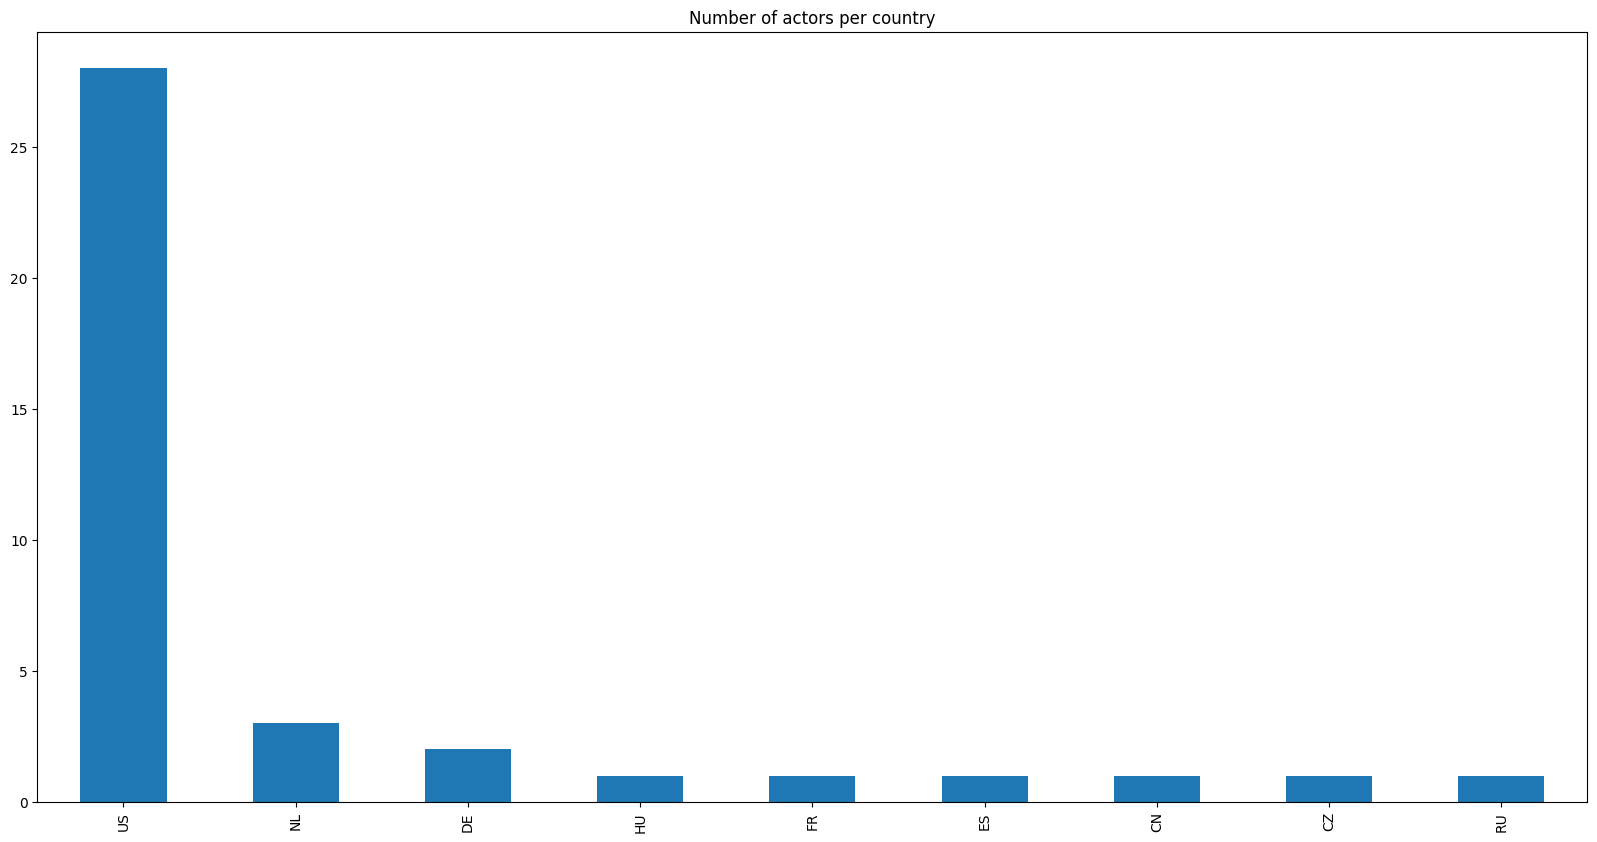

In [36]:
hist = actors_country['nationnality'].value_counts()
hist.plot(kind='bar', figsize=(20, 10))
plt.title('Number of actors per country')

In [37]:
#Plot pie of actors per country
fig = px.pie(hist, values=hist.values, names=hist.index, 
             title='Number of actors per country')
fig.update_traces(textposition='inside', textinfo='label + percent')
fig.show()


In [38]:
us_actors = df_actor[df_actor['nationnality'] == 'US']['identity'].unique()
china_actors = df_actor[df_actor['nationnality'] == 'CN']['identity'].unique()
nl_actors = df_actor[df_actor['nationnality'] == 'NL']['identity'].unique()
de_actors = df_actor[df_actor['nationnality'] == 'DE']['identity'].unique()

us_actors

array(['FortuneJack.com', 'SatoshiMines.com', 'SatoshiDice.com',
       'Loanbase.com', 'Bitstamp.net', 'Paymium.com', 'Poloniex.com',
       'Bitbond.com', 'HolyTransaction.com', 'SlushPool.com',
       'BTCJam.com', 'TheRockTrading.com', 'Huobi.com', 'CoinSpot.com.au',
       'CoinMotion.com', 'Xapo.com', 'CoinGaming.io', 'OKCoin.com',
       'BitZillions.com', 'SecondsTrade.com', 'PocketDice.io',
       'Cryptonator.com', 'BTCC.com', 'CoinPayments.net', 'CoinCafe.com',
       'MercadoBitcoin.com.br', 'Bitcoin.de', 'Vaultoro.com'],
      dtype=object)

In [39]:
def plotActors2(df, actors, title, col, rolling=True):
    
    
    fig = go.Figure()
    for actor in actors:
        ac = df.copy()[df['identity'] == actor]
        len = ac['date'].shape[0]
        xticks = ac['date'][::int(len/6)].values.astype(str)
        
        if (rolling):
            ac[col] = ac[col].rolling(30).mean()
        fig.add_trace(go.Scatter(x=ac['date'], y=ac[col], name=actor))

    fig.update_layout(xaxis=dict(tickvals=xticks, ticktext=xticks, tickangle=20))
    fig.update_layout(title=title)
    fig.update_layout(showlegend=False, legend=dict(x=0, y=0, orientation="v"))
    fig.show()

plotActors2(df_actor, us_actors, 'US actors', 'received')



In [40]:
plotActors2(df_actor, np.array([china_actors, ['Huobi.com']]).flatten(),
             'China actors', 'received')

In [41]:
plotActors2(df_actor, nl_actors, 'Netherlands actors', 'received')

In [42]:
plotActors2(df_actor, de_actors, 'Germany actors', 'received')

Unfortunately, we can not find a link between the actors' countries and their behavior. However, we can see that in the plot of the US actors some similar patterns appear. We will therefore focus on some actors :
- **Huobi**
- **BTCC**
- **Xapo**
- **Bitstamp**
- **OkCoin**

In [43]:
focus_actors = np.array(['Huobi.com', 'Bitstamp.net', 'Xapo.com', 'BTCC.com', 'OKCoin.com'])

In [44]:
plotActors2(df_actor, focus_actors, 'Focus actors', 'received')

In [45]:
# Define a function to convert the date column to datetime
def defineDate(df):
    #df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].apply(lambda x: x.date())


defineDate(df_actor)

In [46]:
# Rolling data to have better comparison
for actor in df_actor['identity'].unique():
    df_actor.loc[df_actor['identity'] == actor, :]['received'] = \
        df_actor[df_actor['identity'] == actor]['received'].rolling(5).mean()
    df_actor.loc[df_actor['identity'] == actor, :]['spent'] = \
        df_actor[df_actor['identity'] == actor]['spent'].rolling(5).mean()

C:\Users\chars\AppData\Local\Temp\ipykernel_19204\1830241601.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\chars\AppData\Local\Temp\ipykernel_19204\1830241601.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
def selectedDate(df, date1, date2):
    df_selected = df[df['date'] >= date1][df['date'] <= date2]
    return df_selected

In [48]:
# Correlation between two actors for a given period
def correlation(df, actor1, actor2, col, date1, date2):
    df_selected_date = selectedDate(df, date1, date2)
    df = df_selected_date
    df[['received', 'spent']] = df[['received', 'spent']]\
        .rolling(30, min_periods=1).mean()
    
    return (np.corrcoef(df[df['identity'] == actor1][col],
            df[df['identity'] == actor2][col]), 
            df_selected_date)

# Correlation between Huobi and Bitstamp from 2015-05-21 to 2015-09-29
# just for the received columm
corr = correlation(df_actor, 'Huobi.com', 'Bitstamp.net', 'received',
            datetime.date(2015, 5, 21), datetime.date(2015, 9, 29))
corr[0]

C:\Users\chars\AppData\Local\Temp\ipykernel_19204\651029845.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



array([[1.        , 0.22182788],
       [0.22182788, 1.        ]])

In [49]:
plotActors2(corr[1], ['Huobi.com', 'Bitstamp.net'], 'Correlation between Huobi and Bitstamp', 'received')

In [50]:
# Correlation between Huobi and BTCC from 2015-10-15 to 2016-01-31
# just for the received columm
corr, plot = correlation(df_actor, 'Huobi.com', 'BTCC.com', 'received', 
            datetime.date(2015, 10, 15), datetime.date(2016, 1, 31))
corr

C:\Users\chars\AppData\Local\Temp\ipykernel_19204\651029845.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



array([[1.        , 0.45408178],
       [0.45408178, 1.        ]])

In [51]:
plotActors2(plot, ['Huobi.com', 'BTCC.com'], 'Correlation between Huobi and BTCC', 'received', rolling=True)

In [52]:
corr, plot = correlation(df_actor, 'Huobi.com', 'OKCoin.com', 'received', 
            datetime.date(2017, 1, 5), datetime.date(2017, 3, 5))
corr

C:\Users\chars\AppData\Local\Temp\ipykernel_19204\651029845.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



array([[1.        , 0.79286858],
       [0.79286858, 1.        ]])

It is particularly interesting to see the evolution of OkCoin on this period which corresponds to the Chinese ban on Bitcoin exchanges in 2017. Its evolution is very similar to Huobi's. 

In [53]:
list_actor = []
for actor in df_actor['identity'].unique():
        try:
                corr, plot = correlation(df_actor, 'Huobi.com', actor, 'received', datetime.date(2017, 1, 5), datetime.date(2017, 3, 5)) 
                if (corr[0, 1] >= 0.7):
                        list_actor.append(actor)
        except:
                continue
list_actor

C:\Users\chars\AppData\Local\Temp\ipykernel_19204\651029845.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\chars\AppData\Local\Temp\ipykernel_19204\651029845.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\chars\AppData\Local\Temp\ipykernel_19204\651029845.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\chars\AppData\Local\Temp\ipykernel_19204\651029845.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\chars\AppData\Local\Temp\ipykernel_19204\651029845.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\chars\AppData\Local\Temp\ipykernel_19204\651029845.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\chars\AppData\Local\Temp\ipykernel_19204\651029845.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame 

['0',
 'Rollin.io',
 'SatoshiDice.com',
 '417',
 'ePay.info_CoinJoinMess',
 '107',
 'Matbea.com',
 'Huobi.com',
 'CoinMotion.com',
 'Xapo.com',
 'CoinGaming.io',
 'OKCoin.com',
 'BitZillions.com',
 'Bter.com',
 '57',
 'BTCC.com',
 'CoinPayments.net',
 'CoinCafe.com',
 'CoinTrader.net_LocalBitcoins.com',
 '74278522',
 '292']

With the correlation function, we can see that Huobi is correlated with other actors from January 2017 to March 2017. We can suppose that these actors had been touched by the Chinese ban on Bitcoin exchanges. 